# PUC Minas - Trabalho de Conclusão de Curso

## Machine Learning e a Integração de Dados Heterogêneos

### Importando as bibliotecas necessárias (configuração do banco de dados não inclusa neste notebook)

In [1]:
import copy
import numbers
import tensorflow
import numpy as np
import mysql.connector
from decimal import Decimal
from tensorflow import keras
import matplotlib.pyplot as plt
from mysql.connector import Error
from random import randrange, randint, shuffle
from sklearn.preprocessing import StandardScaler

### Conectando ao banco de dados e extraindo dados para lista de trabalho interna

In [2]:
try:
    connection = mysql.connector.connect(host='localhost', database='iss', user='root', password='roger', charset='utf8', use_unicode=True)
    print(connection.is_connected())
    cursor = connection.cursor()
        
    db_dados = list()
    for tab_coletada in range(30):
        cod_tabela = randint(1, 324)
        tabela = 'iss_prefeitura_' + str('{0:03}'.format(cod_tabela))
        
        cursor.execute('desc ' + tabela)
        table = cursor.fetchall()
        data = list()
        for k in table:
            data.append([k[0], k[1].split('(')[0]])
        
        cursor.execute('select * from ' + tabela + ' where id <= 1000')
        reg = cursor.fetchall()
        index = 0
        size = len(data)
        for val in reg:
            valores = copy.deepcopy(data)
            for item in val:
                if type(item) == Decimal:
                    valores[index].append(float(item))
                else:
                    valores[index].append(item)
                index += 1
                if index == size:
                    index = 0
            db_dados.append(valores)

except Error as erro:
    print("Problemas de Conecção:", erro)
finally:
    if (connection.is_connected()):
        cursor.close()
        connection.close()
        print("Conecção Encerrada!")

True
Conecção Encerrada!


### Verificando dados importados

In [3]:
print(len(db_dados))
print(type(db_dados))
print("Primeiro Item:", db_dados[0])

30000
<class 'list'>
Primeiro Item: [['Id', 'int', 1], ['Item_Cosif', 'varchar', '10000000'], ['Base_anterior', 'double', 73267.03], ['Base_atual', 'decimal', 76930.38], ['Aliquota', 'decimal', 5.0], ['Tributavel', 'tinyint', 0], ['Total_recolhido', 'double', 3846.52]]


### Extraindo os tipos dos dados coletados e as tags (rótulos) para a fase de treino posterior

In [4]:
tipos = set()
tags = set()
for value in db_dados:
    del value[0]
    for reg in value:
        tipos.add(reg[1])
        tags.add(reg[0])
tipos = list(tipos)
tags = list(tags)

### Analisando os tipos e tags extraídos

In [5]:
print(tipos)
print(tags)

['varchar', 'float', 'char', 'tinyint', 'tinytext', 'double', 'decimal']
['Base_anterior', 'Item_Cosif', 'Tributavel', 'Aliquota', 'Total_recolhido', 'Base_atual']


### One Hot Encoding (OHE) sem uso de bibliotecas para melhor legibilidade

In [6]:
for cat in tipos:
    exec('cat_' + cat + ' = np.zeros(len(tipos))')
    exec('cat_' + cat + '[tipos.index(cat)] = 1')
    
for cat in tags:
    exec('tag_' + cat + ' = np.zeros(len(tags))')
    exec('tag_' + cat + '[tags.index(cat)] = 1')

### Analisando os vetores (OHE)

In [7]:
for k in tipos:
    print(eval('cat_' + k), k)

[1. 0. 0. 0. 0. 0. 0.] varchar
[0. 1. 0. 0. 0. 0. 0.] float
[0. 0. 1. 0. 0. 0. 0.] char
[0. 0. 0. 1. 0. 0. 0.] tinyint
[0. 0. 0. 0. 1. 0. 0.] tinytext
[0. 0. 0. 0. 0. 1. 0.] double
[0. 0. 0. 0. 0. 0. 1.] decimal


In [8]:
for k in tags:
    print(eval('tag_' + k), k)

[1. 0. 0. 0. 0. 0.] Base_anterior
[0. 1. 0. 0. 0. 0.] Item_Cosif
[0. 0. 1. 0. 0. 0.] Tributavel
[0. 0. 0. 1. 0. 0.] Aliquota
[0. 0. 0. 0. 1. 0.] Total_recolhido
[0. 0. 0. 0. 0. 1.] Base_atual


### Registros ordenados conforme tables do banco do dados

In [9]:
db_dados[0]

[['Item_Cosif', 'varchar', '10000000'],
 ['Base_anterior', 'double', 73267.03],
 ['Base_atual', 'decimal', 76930.38],
 ['Aliquota', 'decimal', 5.0],
 ['Tributavel', 'tinyint', 0],
 ['Total_recolhido', 'double', 3846.52]]

### Função 'shuffle' para emular dados semiestruturados

In [10]:
for reg in db_dados:
    shuffle(reg)

### Registros randomizados

In [11]:
db_dados[0]

[['Base_anterior', 'double', 73267.03],
 ['Item_Cosif', 'varchar', '10000000'],
 ['Tributavel', 'tinyint', 0],
 ['Base_atual', 'decimal', 76930.38],
 ['Aliquota', 'decimal', 5.0],
 ['Total_recolhido', 'double', 3846.52]]

### Construindo vetores de 'input' - valor a ser rotulado, demais valores e OHE

In [12]:
x = []
y = []
for reg in db_dados:
    inp = []
    for val in range(len(reg)):
        if isinstance(reg[val][2], numbers.Number):
            inp.append(float(reg[val][2]))
        elif reg[val][2] == 'S':
            inp.append(1.)
        else:
            inp.append(0.)
    x.append(np.hstack((np.array([inp[0]]), inp[1:], eval('cat_' + reg[0][1]))))
    y.append(eval('tag_' + reg[0][0]))
x = np.array(x)
y = np.array(y)

### Normalizando os dados para melhor performance da fase de treino

In [13]:
sc = StandardScaler()
x = sc.fit_transform(x)

### Visualizando primeiro vetor 'normalizado'

In [14]:
x[:1]

array([[ 1.9267361 , -0.5908623 , -0.58964479,  2.05609435, -0.58511969,
        -0.45813864, -0.32675071, -0.48516113, -0.28556747, -0.31301128,
        -0.27456229,  1.58029071, -0.48799031]])

### Criando rede neural para processamento dos dados tratados anteriormente

In [15]:
modelo = keras.Sequential([ 
    keras.layers.Dense(50, activation=tensorflow.nn.relu, input_shape=x.shape[1:]),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(50, activation=tensorflow.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(6, activation=tensorflow.nn.softmax)
])

modelo.compile(optimizer='adam', 
               loss='categorical_crossentropy',
               metrics=['accuracy'])

historico = modelo.fit(x, y, epochs=30, validation_split=0.2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 24000 samples, validate on 6000 samples
Epoch 1/30
24000/24000 [==============================] - 1s 39us/sample - loss: 0.6585 - acc: 0.6731 - val_loss: 0.5418 - val_acc: 0.6590
Epoch 2/30
24000/24000 [==============================] - 1s 36us/sample - loss: 0.4782 - acc: 0.7187 - val_loss: 0.5446 - val_acc: 0.6072
Epoch 3/30
24000/24000 [==============================] - 1s 35us/sample - loss: 0.4644 - acc: 0.7231 - val_loss: 0.5337 - val_acc: 0.6598
Epoch 4/30
24000/24000 [==============================] - 1s 34us/sample - loss: 0.4570 - acc: 0.7263 - val_loss: 0.5385 - val_acc: 0.6270
Epoch 5/30
24000/24000 [==============================] - 1s 34us/sample - loss: 0.4519 - acc: 0.7342 - val_loss: 0.5322 - val_acc: 0.6443
Epoch 6/30
24000/24000 [==============================] - 1s 39us/sample - loss: 0.4447 - acc: 0.7391 - val_loss: 0.5129 - val_acc: 0.6820
Epoch 7/30
24000/24000 [============

### 'Plotando' dados de acurácia para avaliação do modelo

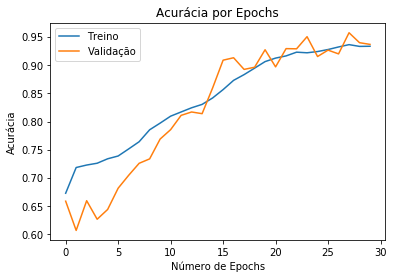

In [16]:
plt.plot(historico.history['acc'])
plt.plot(historico.history['val_acc'])
plt.title('Acurácia por Epochs')
plt.xlabel('Número de Epochs')
plt.ylabel('Acurácia')
plt.legend(['Treino', 'Validação'])

### 'Plotando' dados da função de perda para avaliação do modelo

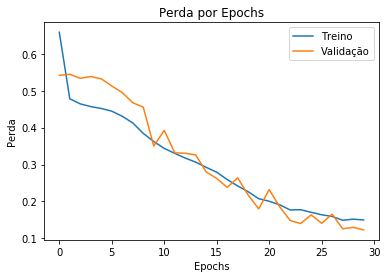

In [17]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('Perda por Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perda')
plt.legend(['Treino', 'Validação'])

### Salvando modelo para análises futura

In [18]:
modelo.save('TccPUC')